In [1]:
import warnings
import numpy as np
import scipy.io.wavfile as wf
import audacity as au
import matplotlib.pyplot as plt

%matplotlib notebook

In [2]:
### Function definitions
def spectrumToWaveform(spectrum, numPoints):
    '''
    Calculates the waveform for a given spectrum using the ifft.
    '''
    
    harmHi = int(np.floor(numPoints/2))
    # throw out any frequency components that will not contribute
    if len(spectrum) > (harmHi + 1):
        spectrum = spectrum[ : harmHi + 1]
        warnings.warn('Some spectrum points have been thrown out!')
    # fill the spectrum out to the Nyquist limit
    if len(spectrum) < (harmHi + 1):
        spectrum.extend([0 for z in range(harmHi+2-len(spectrum))])

    # fix up the dc component
    spectrum = [z*2 for z in spectrum]
        
    # un-normalise the points
    spectrum = [z*numPoints/2 for z in spectrum]
    # add the extra points
    newPoints = spectrum[1 : int(np.ceil(numPoints / 2))]
    newPoints = [np.conj(z) for z in spectrum]
    newPoints = newPoints[::-1]
    spectrum.extend(newPoints)
    spectrum = np.array(spectrum)
    # take the ifft
    waveform = np.fft.ifft(spectrum, numPoints)
    waveform = np.real(waveform)
    return waveform

def waveformToSpectrum(waveform, numPoints):
    '''
    Calculates the spectrum for a given waveform using the fft.
    '''

    # take the fft
    spectrum = np.fft.fft(waveform, numPoints)
    # only keep those points out to the harmHi'th harmonic
    harmHi = int(np.floor(numPoints/2))
    spectrum = spectrum[ : harmHi + 1]
    # normalise the points
    spectrum = [z*2/numPoints for z in spectrum]
    # fix up the dc component
    spectrum = [z/2 for z in spectrum]
    return spectrum

def randomisePhase(output, numTrials=25):
    numPoints = len(output.waveform)
    ampSum = np.sum(np.abs(output.spectrum))
    testwaveforms = []
    
    for trial in range(numTrials):
        # calculate a random phase change
        phaseChange = (np.random.rand(len(output.spectrum)) - 0.5) * 2*np.pi
        # apply the phase change
        newSpectrum = [z*np.exp(complex(0,phaseChange[i])) for i, z in enumerate(output.spectrum)]
        # calculate the new output waveform
        newWaveform = spectrumToWaveform(newSpectrum, numPoints)
        testwaveforms.append(newWaveform)
        # calculate alpha for the new waveform
        newAlpha = ampSum / np.max(np.abs(newWaveform))
        if newAlpha > output.alpha:
            output.waveform = newWaveform
            output.alpha = newAlpha
    
    # Normalise the output waveform to 99%
    output.waveform = 0.99 * output.waveform / np.max(np.abs(output.waveform))

    # Recalculate the output spectrum
    output.spectrum = waveformToSpectrum(output.waveform, numPoints)
    
    return Output(output.spectrum, output.waveform, output.alpha), testwaveforms

In [3]:
### Output object
class Output(object):
    
    def __init__(self, spectrum, waveform, alpha):
        self.spectrum = spectrum
        self.waveform = waveform
        self.alpha = alpha
        

In [4]:
### Input parameters
samplingFreq = 44100
bitDepth = 16
numPoints = 2**13
freqLo = 200
freqHi = 4000
numCycles = 32
modf = 2*2**13/numPoints

# Desired length [sec] - approx.
noiseLen = 60

In [5]:
### Initial harmonics
freqIncr = samplingFreq/numPoints
freqNyquist = samplingFreq/2
harmLo = int(np.floor(freqLo/freqIncr))
harmHi = int(np.ceil(freqHi/freqIncr))
freqLo = harmLo*freqIncr
freqHi = harmHi*freqIncr
print(harmHi, harmLo)

744 37


/home/leon/Directories/anaconda3/envs/legato-transients/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Some spectrum points have been thrown out!
  # This is added back by InteractiveShellApp.init_path()


float32 (2654208,) [-0.013426   -0.1477256  -0.24496035 ...,  0.36031541  0.26823065
  0.13463242] 324


<IPython.core.display.Javascript object>


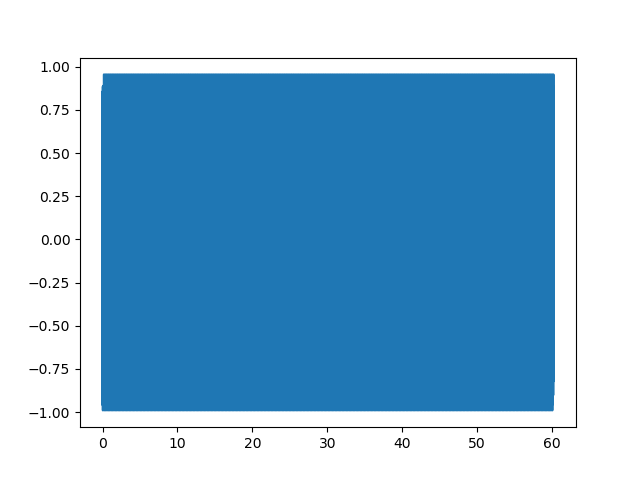

In [20]:
### Generating output
spectrum = [0 for z in range(harmHi+1)]
spectrum[harmLo+1 : ] = [1 for z in range(len(spectrum)-harmLo+1)]
testspectrum = spectrum
waveform = spectrumToWaveform(spectrum, numPoints)
testwave = waveform
alpha = np.sum(np.abs(spectrum))/np.max(np.abs(waveform))
output = Output(spectrum, waveform, alpha)
output = randomisePhase(output, numTrials=25)[0]

noise = []
numRepeats = int(np.ceil(
    noiseLen/(np.arange(len(output.waveform))/samplingFreq)[-1]))
for n in range(numRepeats):
    noise.extend(output.waveform)

noise = np.array(noise, dtype='float32')
print(noise.dtype, noise.shape, noise, numRepeats)
    
wf.write("ALL_DATA/2801SineNoise.wav", samplingFreq, noise)

plt.figure()
plt.plot(np.arange(len(noise))/samplingFreq, noise)